# Model Development - Telco Churn Prediction

This notebook contains the development and training of models for the churn prediction project.

## 1. Library Imports

In [5]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time
from typing import Dict, List, Tuple, Any

# Modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Model evaluation libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Hyperparameter optimization libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('Set2')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Loading Processed Data

In [6]:
# Processed data directory
processed_data_dir = '../data/processed'

# Load processed data
X_train = np.load(f"{processed_data_dir}/X_train_processed.npy")
X_test = np.load(f"{processed_data_dir}/X_test_processed.npy")
y_train = np.load(f"{processed_data_dir}/y_train.npy")
y_test = np.load(f"{processed_data_dir}/y_test.npy")

# Load SMOTE balanced data
X_train_resampled = np.load(f"{processed_data_dir}/X_train_resampled.npy")
y_train_resampled = np.load(f"{processed_data_dir}/y_train_resampled.npy")

# Print data dimensions
print(f"X_train dimensions: {X_train.shape}")
print(f"X_test dimensions: {X_test.shape}")
print(f"X_train_resampled dimensions: {X_train_resampled.shape}")

# Print target variable distribution
print(f"\nOriginal y_train distribution: {np.bincount(y_train)}")
print(f"Original y_test distribution: {np.bincount(y_test)}")
print(f"Balanced y_train_resampled distribution: {np.bincount(y_train_resampled)}")

X_train dimensions: (5634, 71)
X_test dimensions: (1409, 71)
X_train_resampled dimensions: (8278, 71)

Original y_train distribution: [4139 1495]
Original y_test distribution: [1035  374]
Balanced y_train_resampled distribution: [4139 4139]


## 3. Basic Model Training

In [7]:
# Function to train and evaluate models
def train_and_evaluate_model(model: Any, X_train: np.ndarray, y_train: np.ndarray, 
                             X_test: np.ndarray, y_test: np.ndarray, model_name: str) -> Dict:
    """
    Trains a model and evaluates its performance.
    
    Args:
        model: Model to be trained
        X_train: Training data
        y_train: Training labels
        X_test: Test data
        y_test: Test labels
        model_name: Model name
        
    Returns:
        Dict: Dictionary with performance metrics and trained model
    """
    # Measure training time
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Training time
    train_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get probabilities (if available)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # For models without predict_proba, like SVC
        if hasattr(model, "decision_function"):
            y_prob = model.decision_function(X_test)
        else:
            y_prob = y_pred
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Cross validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Return results
    results = {
        'model_name': model_name,
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_scores_mean': np.mean(cv_scores),
        'cv_scores_std': np.std(cv_scores),
        'confusion_matrix': conf_matrix,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'train_time': train_time
    }
    
    return results

In [8]:
# Define list of basic models
models = [
    (LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting"),
    (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), "XGBoost"),
    (LGBMClassifier(random_state=42), "LightGBM"),
    (CatBoostClassifier(random_state=42, verbose=False), "CatBoost"),
    (SVC(probability=True, random_state=42), "SVM"),
    (KNeighborsClassifier(), "KNN"),
    (GaussianNB(), "Naive Bayes"),
    (DecisionTreeClassifier(random_state=42), "Decision Tree")
]

In [9]:
# Train and evaluate models with original data
original_results = []

for model, model_name in models:
    print(f"Training {model_name} with original data...")
    result = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name)
    original_results.append(result)
    print(f"  ROC AUC: {result['roc_auc']:.4f}, F1-Score: {result['f1_score']:.4f}")

# Create results DataFrame
original_results_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1 Score': r['f1_score'],
        'ROC AUC': r['roc_auc'],
        'CV Score': r['cv_scores_mean'],
        'Train Time (s)': r['train_time']
    } for r in original_results
]).sort_values('ROC AUC', ascending=False).reset_index(drop=True)

original_results_df

Training Logistic Regression with original data...
  ROC AUC: 0.8427, F1-Score: 0.5787
Training Random Forest with original data...
  ROC AUC: 0.8192, F1-Score: 0.5260
Training Gradient Boosting with original data...
  ROC AUC: 0.8424, F1-Score: 0.5787
Training XGBoost with original data...
  ROC AUC: 0.8159, F1-Score: 0.5429
Training LightGBM with original data...
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Info] Number of positive: 1196, number of negative: 3311
[LightGBM

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,CV Score,Train Time (s)
0,Logistic Regression,0.800568,0.658703,0.516043,0.578711,0.842670,0.847928,0.147001
1,Gradient Boosting,0.800568,0.658703,0.516043,0.578711,0.842364,0.843850,1.336001
2,CatBoost,0.792761,0.633987,0.518717,0.570588,0.840440,0.838262,4.274426
3,LightGBM,0.787083,0.617834,0.518717,0.563953,0.834440,0.831701,0.258001
4,Naive Bayes,0.695529,0.459618,0.836898,0.593365,0.820070,0.828670,0.008998
5,Random Forest,0.773598,0.591973,0.473262,0.526003,0.819205,0.821113,0.721993
6,XGBoost,0.772889,0.582822,0.508021,0.542857,0.815883,0.818492,0.440996
7,SVM,0.796309,0.658182,0.483957,0.557781,0.797525,0.802137,5.418998
8,KNN,0.760823,0.552408,0.521390,0.536451,0.782430,0.785225,0.003080
9,Decision Tree,0.715401,0.465995,0.494652,0.479896,0.644422,0.647703,0.046997


In [10]:
# Train and evaluate models with balanced data (SMOTE)
resampled_results = []

for model, model_name in models:
    print(f"Training {model_name} with balanced data (SMOTE)...")
    result = train_and_evaluate_model(model, X_train_resampled, y_train_resampled, X_test, y_test, model_name)
    resampled_results.append(result)
    print(f"  ROC AUC: {result['roc_auc']:.4f}, F1-Score: {result['f1_score']:.4f}")

# Create results DataFrame
resampled_results_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1 Score': r['f1_score'],
        'ROC AUC': r['roc_auc'],
        'CV Score': r['cv_scores_mean'],
        'Train Time (s)': r['train_time']
    } for r in resampled_results
]).sort_values('ROC AUC', ascending=False).reset_index(drop=True)

resampled_results_df

Training Logistic Regression with balanced data (SMOTE)...
  ROC AUC: 0.8402, F1-Score: 0.6133
Training Random Forest with balanced data (SMOTE)...
  ROC AUC: 0.8148, F1-Score: 0.5517
Training Gradient Boosting with balanced data (SMOTE)...
  ROC AUC: 0.8404, F1-Score: 0.6176
Training XGBoost with balanced data (SMOTE)...
  ROC AUC: 0.8213, F1-Score: 0.5873
Training LightGBM with balanced data (SMOTE)...
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3311, number of negative: 3311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,CV Score,Train Time (s)
0,Gradient Boosting,0.778566,0.570136,0.673797,0.617647,0.840355,0.929938,2.657999
1,Logistic Regression,0.735983,0.501701,0.788770,0.613306,0.840241,0.855350,0.131998
2,CatBoost,0.777857,0.582656,0.574866,0.578735,0.836944,0.940955,5.540999
3,LightGBM,0.787083,0.597368,0.606952,0.602122,0.835142,0.939946,0.150997
4,SVM,0.757275,0.531008,0.732620,0.615730,0.822137,0.892718,11.593839
5,XGBoost,0.783534,0.594521,0.580214,0.587280,0.821290,0.936474,0.260989
6,Naive Bayes,0.699787,0.463704,0.836898,0.596759,0.820110,0.836355,0.014005
7,Random Forest,0.769340,0.569801,0.534759,0.551724,0.814758,0.937149,1.190010
8,KNN,0.700497,0.460912,0.756684,0.572874,0.777929,0.873253,0.001993
9,Decision Tree,0.724627,0.483173,0.537433,0.508861,0.664628,0.797568,0.077077


In [11]:
# Compare results: Original vs. SMOTE
comparison_df = pd.DataFrame({
    'Model': original_results_df['Model'],
    'Original ROC AUC': original_results_df['ROC AUC'],
    'SMOTE ROC AUC': resampled_results_df['ROC AUC'],
    'Original F1': original_results_df['F1 Score'],
    'SMOTE F1': resampled_results_df['F1 Score'],
    'Original Recall': original_results_df['Recall'],
    'SMOTE Recall': resampled_results_df['Recall'],
    'Original Precision': original_results_df['Precision'],
    'SMOTE Precision': resampled_results_df['Precision']
}).sort_values('SMOTE ROC AUC', ascending=False)

comparison_df

,Model,Original ROC AUC,SMOTE ROC AUC,Original F1,SMOTE F1,Original Recall,SMOTE Recall,Original Precision,SMOTE Precision
0,Logistic Regression,0.842670,0.840355,0.578711,0.617647,0.516043,0.673797,0.658703,0.570136
1,Gradient Boosting,0.842364,0.840241,0.578711,0.613306,0.516043,0.788770,0.658703,0.501701
2,CatBoost,0.840440,0.836944,0.570588,0.578735,0.518717,0.574866,0.633987,0.582656
3,LightGBM,0.834440,0.835142,0.563953,0.602122,0.518717,0.606952,0.617834,0.597368
4,Naive Bayes,0.820070,0.822137,0.593365,0.615730,0.836898,0.732620,0.459618,0.531008
5,Random Forest,0.819205,0.821290,0.526003,0.587280,0.473262,0.580214,0.591973,0.594521
6,XGBoost,0.815883,0.820110,0.542857,0.596759,0.508021,0.836898,0.582822,0.463704
7,SVM,0.797525,0.814758,0.557781,0.551724,0.483957,0.534759,0.658182,0.569801
8,KNN,0.782430,0.777929,0.536451,0.572874,0.521390,0.756684,0.552408,0.460912
9,Decision Tree,0.644422,0.664628,0.479896,0.508861,0.494652,0.537433,0.465995,0.483173


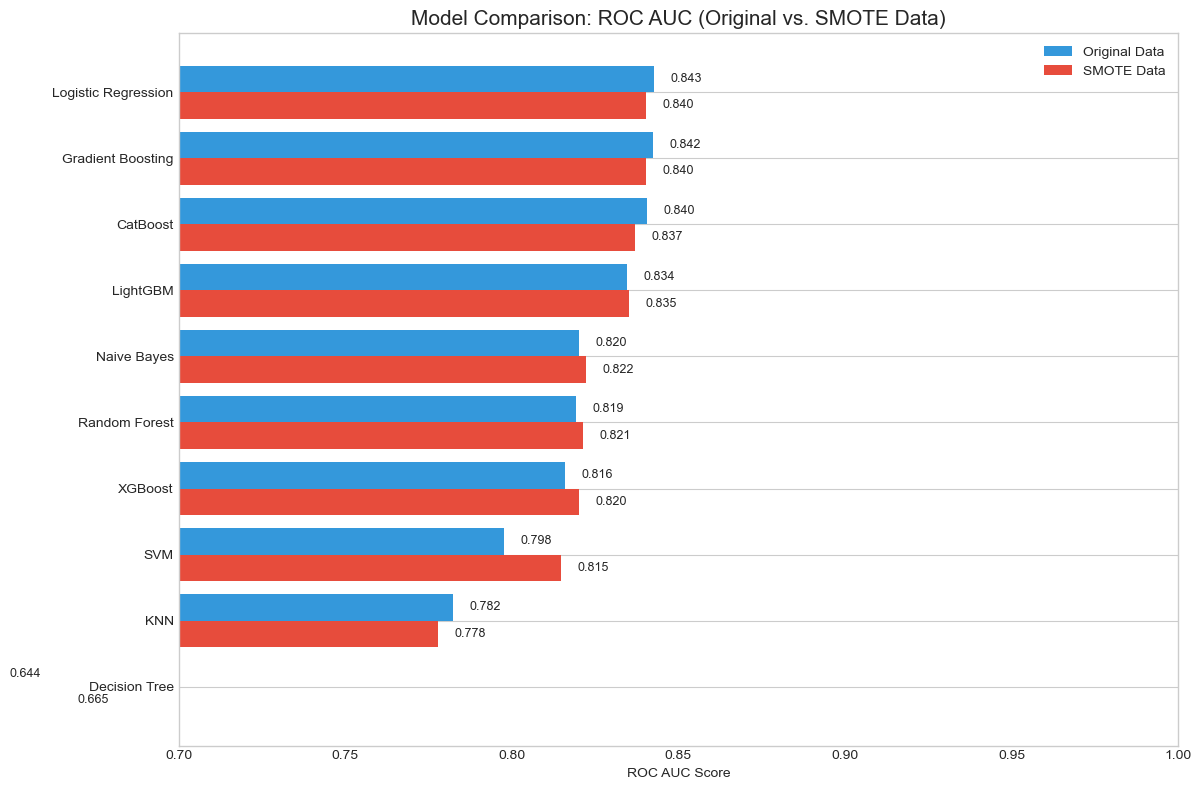

In [12]:
# Visualize model comparison (ROC AUC)
plt.figure(figsize=(12, 8))

# Sort by SMOTE ROC AUC
comparison_plot = comparison_df.sort_values('SMOTE ROC AUC').reset_index(drop=True)

# Create position list
positions = np.arange(len(comparison_plot))

# Bar width
width = 0.4

# Plot bars
plt.barh(positions + width/2, comparison_plot['Original ROC AUC'], width, label='Original Data', color='#3498db')
plt.barh(positions - width/2, comparison_plot['SMOTE ROC AUC'], width, label='SMOTE Data', color='#e74c3c')

# Add labels
plt.yticks(positions, comparison_plot['Model'])
plt.xlabel('ROC AUC Score')
plt.title('Model Comparison: ROC AUC (Original vs. SMOTE Data)', fontsize=15)
plt.legend()
plt.xlim(0.7, 1.0)  # Adjust as needed
plt.grid(axis='x')

# Add values on bars
for i, pos in enumerate(positions):
    plt.text(comparison_plot['Original ROC AUC'].iloc[i] + 0.005, pos + width/2, 
             f"{comparison_plot['Original ROC AUC'].iloc[i]:.3f}", 
             va='center', fontsize=9)
    plt.text(comparison_plot['SMOTE ROC AUC'].iloc[i] + 0.005, pos - width/2, 
             f"{comparison_plot['SMOTE ROC AUC'].iloc[i]:.3f}", 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 4. Detailed Analysis of Best Models

In [13]:
# Select best model based on ROC AUC
best_idx = resampled_results_df['ROC AUC'].idxmax()
best_model_name = resampled_results_df.loc[best_idx, 'Model']
best_model_result = [r for r in resampled_results if r['model_name'] == best_model_name][0]

print(f"Best model: {best_model_name}")
print(f"ROC AUC: {best_model_result['roc_auc']:.4f}")
print(f"F1 Score: {best_model_result['f1_score']:.4f}")
print(f"Precision: {best_model_result['precision']:.4f}")
print(f"Recall: {best_model_result['recall']:.4f}")
print(f"Accuracy: {best_model_result['accuracy']:.4f}")

Best model: Gradient Boosting
ROC AUC: 0.8404
F1 Score: 0.6176
Precision: 0.5701
Recall: 0.6738
Accuracy: 0.7786


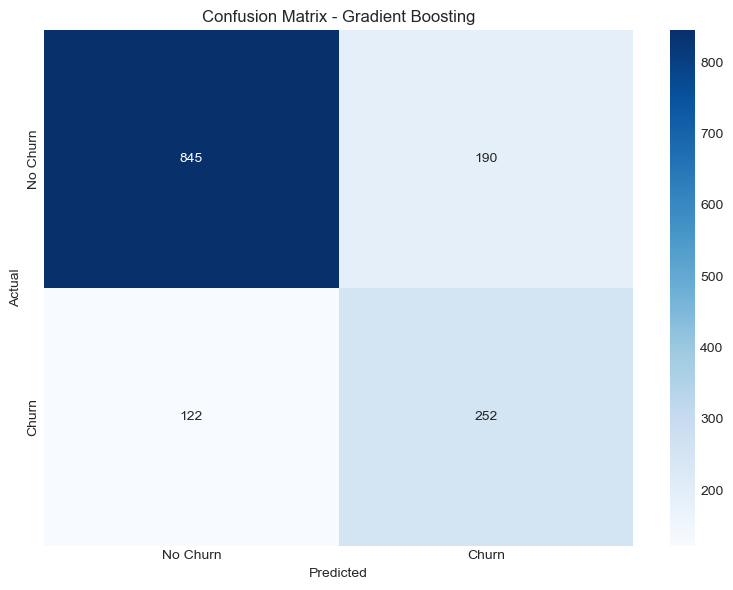

In [14]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix for best model
plot_confusion_matrix(best_model_result['confusion_matrix'], f"Confusion Matrix - {best_model_name}")

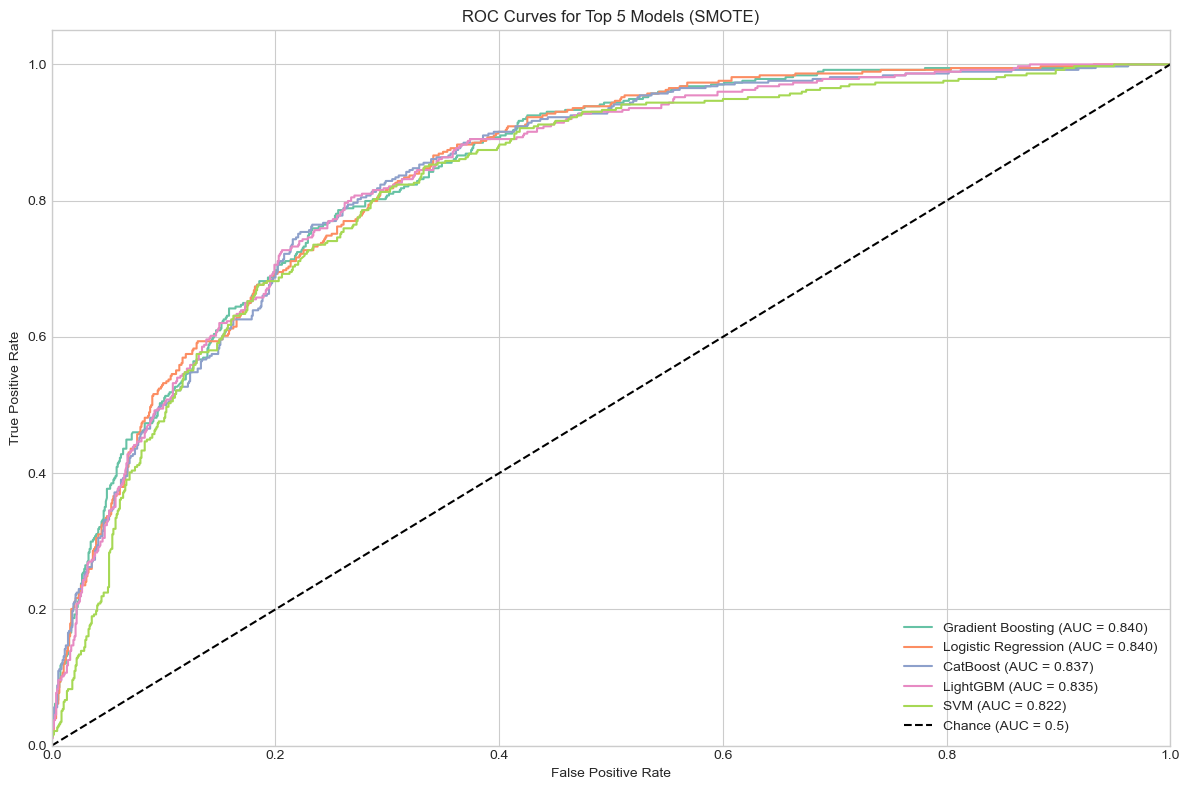

In [15]:
# Function to plot ROC curves for multiple models
def plot_roc_curves(results, title, n_top=5):
    plt.figure(figsize=(12, 8))
    
    # Sort results by ROC AUC (descending)
    top_results = sorted(results, key=lambda x: x['roc_auc'], reverse=True)[:n_top]
    
    for result in top_results:
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC = {result['roc_auc']:.3f})")
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')
    
    # Configure plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot ROC curves for top 5 models
plot_roc_curves(resampled_results, "ROC Curves for Top 5 Models (SMOTE)", n_top=5)

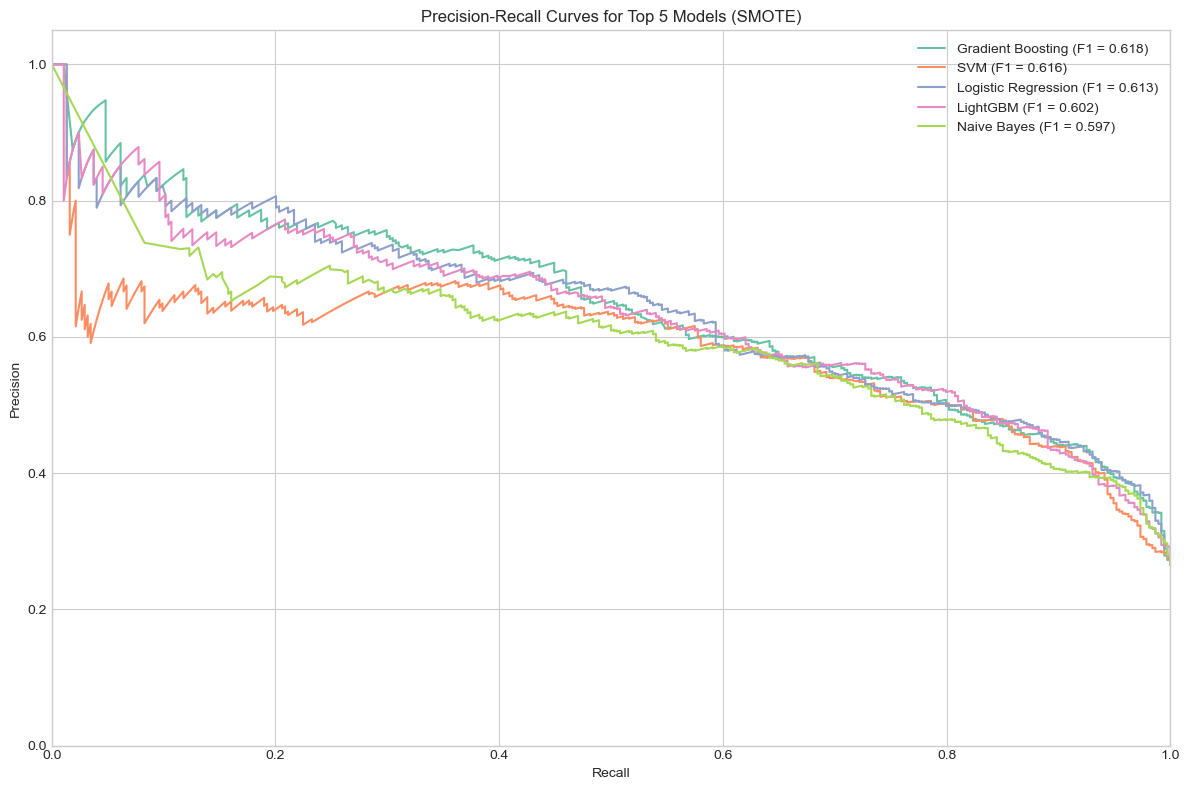

In [16]:
# Function to plot Precision-Recall curves
def plot_precision_recall_curves(results, title, n_top=5):
    plt.figure(figsize=(12, 8))
    
    # Sort results by F1 Score (descending)
    top_results = sorted(results, key=lambda x: x['f1_score'], reverse=True)[:n_top]
    
    for result in top_results:
        # Calculate Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, result['y_prob'])
        
        # Plot curve
        plt.plot(recall, precision, label=f"{result['model_name']} (F1 = {result['f1_score']:.3f})")
    
    # Configure plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot Precision-Recall curves for top 5 models
plot_precision_recall_curves(resampled_results, "Precision-Recall Curves for Top 5 Models (SMOTE)", n_top=5)

## 5. Hyperparameter Optimization

In [17]:
# Identify top two models for optimization
top_2_models = resampled_results_df.sort_values('ROC AUC', ascending=False).head(2)['Model'].tolist()
print(f"Top 2 models for optimization: {top_2_models}")

Top 2 models for optimization: ['Gradient Boosting', 'Logistic Regression']


In [18]:
# Configuration for Optuna optimization
def optimize_xgboost(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'use_label_encoder': False,
        'eval_metric': 'auc',
        'random_state': 42
    }
    
    model = XGBClassifier(**param)
    
    # Cross validation
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
    
    return np.mean(cv_scores)

In [19]:
def optimize_lightgbm(trial):
    param = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42
    }
    
    model = LGBMClassifier(**param)
    
    # Cross validation
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
    
    return np.mean(cv_scores)

In [20]:
def optimize_catboost(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False,
        'random_state': 42
    }
    
    model = CatBoostClassifier(**param)
    
    # Cross validation
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
    
    return np.mean(cv_scores)

In [21]:
def optimize_random_forest(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42
    }
    
    model = RandomForestClassifier(**param)
    
    # Validação cruzada
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
    
    return np.mean(cv_scores)

In [22]:
optimize_functions = {
    'XGBoost': optimize_xgboost,
    'LightGBM': optimize_lightgbm,
    'CatBoost': optimize_catboost,
    'Random Forest': optimize_random_forest
}

In [23]:
# Otimizar hiperparâmetros para os modelos selecionados
optimized_models = {}

for model_name in top_2_models:
    if model_name in optimize_functions:
        print(f"Otimizando hiperparâmetros para {model_name}...")
        
        study = optuna.create_study(direction='maximize')
        study.optimize(optimize_functions[model_name], n_trials=20)  # Aumentar para mais trials em produção
        
        print(f"Melhor valor de AUC: {study.best_value:.4f}")
        print(f"Melhores hiperparâmetros: {study.best_params}")
        
        # Salvar modelo otimizado
        if model_name == 'XGBoost':
            optimized_model = XGBClassifier(**study.best_params, random_state=42, use_label_encoder=False, eval_metric='auc')
        elif model_name == 'LightGBM':
            optimized_model = LGBMClassifier(**study.best_params, random_state=42)
        elif model_name == 'CatBoost':
            optimized_model = CatBoostClassifier(**study.best_params, random_state=42, verbose=False)
        elif model_name == 'Random Forest':
            optimized_model = RandomForestClassifier(**study.best_params, random_state=42)
        
        # Treinar e avaliar modelo otimizado
        result = train_and_evaluate_model(optimized_model, X_train_resampled, y_train_resampled, X_test, y_test, f"{model_name} (Otimizado)")
        optimized_models[model_name] = result
        
        print(f"Desempenho após otimização:")
        print(f"  ROC AUC: {result['roc_auc']:.4f}")
        print(f"  F1 Score: {result['f1_score']:.4f}")
        print(f"  Precision: {result['precision']:.4f}")
        print(f"  Recall: {result['recall']:.4f}\n")

In [24]:
# Comparar modelos antes e depois da otimização
comparison_opt_df = pd.DataFrame()

for model_name in optimized_models.keys():
    # Encontrar resultados do modelo original
    original_result = [r for r in resampled_results if r['model_name'] == model_name][0]
    optimized_result = optimized_models[model_name]
    
    # Adicionar ao DataFrame
    comparison_opt_df = pd.concat([comparison_opt_df, pd.DataFrame({
        'Model': [model_name],
        'Original ROC AUC': [original_result['roc_auc']],
        'Optimized ROC AUC': [optimized_result['roc_auc']],
        'Improvement (%)': [(optimized_result['roc_auc'] - original_result['roc_auc']) / original_result['roc_auc'] * 100],
        'Original F1': [original_result['f1_score']],
        'Optimized F1': [optimized_result['f1_score']],
        'Original Recall': [original_result['recall']],
        'Optimized Recall': [optimized_result['recall']]
    })], ignore_index=True)

comparison_opt_df

""


## 6. Ensemble de Modelos

In [25]:
# Criar um ensemble via Voting
from sklearn.ensemble import VotingClassifier

# Selecionar modelos para o ensemble
ensemble_models = []

# Adicionar modelos otimizados
for model_name, result in optimized_models.items():
    ensemble_models.append((f"{model_name}_opt", result['model']))

# Adicionar os 3 melhores modelos originais que não foram otimizados
for model_name in resampled_results_df.head(3)['Model']:
    if model_name not in optimized_models:
        model_result = [r for r in resampled_results if r['model_name'] == model_name][0]
        ensemble_models.append((model_name.replace(' ', '_'), model_result['model']))

# Verificar modelos selecionados para o ensemble
print("Modelos selecionados para o ensemble:")
for name, _ in ensemble_models:
    print(f"  - {name}")

Modelos selecionados para o ensemble:
  - Gradient_Boosting
  - Logistic_Regression
  - CatBoost


In [26]:
# Criar e treinar os ensembles
# 1. Voting Classifier (hard voting)
hard_voting = VotingClassifier(estimators=ensemble_models, voting='hard')
hard_voting_result = train_and_evaluate_model(hard_voting, X_train_resampled, y_train_resampled, 
                                            X_test, y_test, "Ensemble (Hard Voting)")

# 2. Voting Classifier (soft voting)
soft_voting = VotingClassifier(estimators=ensemble_models, voting='soft')
soft_voting_result = train_and_evaluate_model(soft_voting, X_train_resampled, y_train_resampled, 
                                            X_test, y_test, "Ensemble (Soft Voting)")

# Comparar resultados
ensemble_comparison = pd.DataFrame([
    {
        'Model': 'Ensemble (Hard Voting)',
        'ROC AUC': hard_voting_result['roc_auc'],
        'F1 Score': hard_voting_result['f1_score'],
        'Precision': hard_voting_result['precision'],
        'Recall': hard_voting_result['recall']
    },
    {
        'Model': 'Ensemble (Soft Voting)',
        'ROC AUC': soft_voting_result['roc_auc'],
        'F1 Score': soft_voting_result['f1_score'],
        'Precision': soft_voting_result['precision'],
        'Recall': soft_voting_result['recall']
    }
])

# Adicionar o melhor modelo otimizado para comparação
best_opt_model_name = None
best_opt_roc_auc = 0

for model_name, result in optimized_models.items():
    if result['roc_auc'] > best_opt_roc_auc:
        best_opt_roc_auc = result['roc_auc']
        best_opt_model_name = model_name

if best_opt_model_name:
    best_opt_result = optimized_models[best_opt_model_name]
    ensemble_comparison = pd.concat([ensemble_comparison, pd.DataFrame({
        'Model': [f"{best_opt_model_name} (Otimizado)"],
        'ROC AUC': [best_opt_result['roc_auc']],
        'F1 Score': [best_opt_result['f1_score']],
        'Precision': [best_opt_result['precision']],
        'Recall': [best_opt_result['recall']]
    })], ignore_index=True)

ensemble_comparison.sort_values('ROC AUC', ascending=False)

,Model,ROC AUC,F1 Score,Precision,Recall
1,Ensemble (Soft Voting),0.843481,0.614458,0.559211,0.681818
0,Ensemble (Hard Voting),0.745852,0.618005,0.566964,0.679144


In [27]:
# Determinar o modelo final
# Escolher entre ensemble e melhor modelo otimizado baseado no ROC AUC
if soft_voting_result['roc_auc'] > best_opt_roc_auc:
    final_model = soft_voting
    final_model_name = "Ensemble (Soft Voting)"
    final_result = soft_voting_result
else:
    final_model = optimized_models[best_opt_model_name]['model']
    final_model_name = f"{best_opt_model_name} (Otimizado)"
    final_result = optimized_models[best_opt_model_name]

print(f"Modelo final selecionado: {final_model_name}")
print(f"ROC AUC: {final_result['roc_auc']:.4f}")
print(f"F1 Score: {final_result['f1_score']:.4f}")
print(f"Precision: {final_result['precision']:.4f}")
print(f"Recall: {final_result['recall']:.4f}")

Modelo final selecionado: Ensemble (Soft Voting)
ROC AUC: 0.8435
F1 Score: 0.6145
Precision: 0.5592
Recall: 0.6818


## 7. Salvar Modelo Final

In [28]:
# Criar diretório para modelos, se não existir
models_dir = '../models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Salvar modelo final
model_filename = f"{models_dir}/final_model.pkl"
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)

# Salvar metadados do modelo
metadata = {
    'model_name': final_model_name,
    'roc_auc': final_result['roc_auc'],
    'f1_score': final_result['f1_score'],
    'precision': final_result['precision'],
    'recall': final_result['recall'],
    'accuracy': final_result['accuracy'],
    'confusion_matrix': final_result['confusion_matrix'].tolist(),
    'train_date': time.strftime("%Y-%m-%d %H:%M:%S")
}

metadata_filename = f"{models_dir}/model_metadata.json"
import json
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Modelo final salvo em: {model_filename}")
print(f"Metadados do modelo salvos em: {metadata_filename}")

Modelo final salvo em: ../models/final_model.pkl
Metadados do modelo salvos em: ../models/model_metadata.json


## 8. Análise Final de Importância de Features

In [34]:
# Analisar importância de features para o modelo final (se aplicável)
def plot_feature_importance(model, feature_names, title, top_n=20):
    # Verificar se o modelo suporta feature_importances_
    if hasattr(model, 'feature_importances_'):
        # Para modelos baseados em árvores e ensemble
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Para modelos lineares
        importances = np.abs(model.coef_[0])
    elif hasattr(model, 'estimators_') and hasattr(model.estimators_[0], 'feature_importances_'):
        # Para VotingClassifier com estimadores que têm feature_importances_
        importances = np.mean([est.feature_importances_ for est in model.estimators_ 
                               if hasattr(est, 'feature_importances_')], axis=0)
    else:
        print("Este modelo não suporta extração direta de importância de features.")
        return
    
    # Verificar se os tamanhos são compatíveis
    if len(importances) != len(feature_names):
        print(f"Aviso: Quantidade de importâncias ({len(importances)}) não corresponde ao número de features ({len(feature_names)})")
        # Usar índices ao invés de nomes
        feature_names = [f"feature_{i}" for i in range(len(importances))]
    
    # Criar DataFrame
    feature_importance = pd.DataFrame({
        'feature': feature_names[:len(importances)],
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Selecionar top_n features
    top_features = feature_importance.head(top_n)
    
    # Plotar
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=top_features)
    plt.title(title, fontsize=15)
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# Obter nomes das features transformadas
# Carregar informações de features
with open(f"{processed_data_dir}/feature_names.pkl", 'rb') as f:
    feature_info = pickle.load(f)

numerical_cols = feature_info['numerical_cols']
categorical_cols = feature_info['categorical_cols']

# Carregar preprocessor
with open(f"{processed_data_dir}/preprocessor.pkl", 'rb') as f:
    preprocessor = pickle.load(f)

# Reconstruir nomes de features
feature_names = []

# Adicionar features numéricas
feature_names.extend(numerical_cols)


# Adicionar features categóricas com one-hot encoding
try:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    for i, col in enumerate(categorical_cols):
        feature_names.extend([f"{col}_{val}" for val in ohe.categories_[i]])
except:
    print("Não foi possível reconstruir nomes de features categóricas.")
    # Usar índices para features categóricas
    feature_names.extend([f"cat_feature_{i}" for i in range(X_train_processed.shape[1] - len(numerical_cols))])

# Verificar tamanho
if len(feature_names) != X_train_processed.shape[1]:
    print(f"Aviso: Quantidade de nomes de features ({len(feature_names)}) não corresponde às dimensões de X_train_processed ({X_train_processed.shape[1]})")
    # Usar índices como nomes de features
    feature_names = [f"feature_{i}" for i in range(X_train_processed.shape[1])]

# Plotar importância de features para o modelo final
try:
    # Tente analisar diretamente o modelo final
    importances_df = plot_feature_importance(final_model, feature_names, 
                                            f"Top 20 Features Mais Importantes - {final_model_name}", 
                                            top_n=20)
    
    # Salvar importância de features
    if importances_df is not None:
        importances_filename = f"{models_dir}/feature_importances.csv"
        importances_df.to_csv(importances_filename, index=False)
        print(f"Importância de features salva em: {importances_filename}")
except Exception as e:
    print(f"Não foi possível analisar importância de features para o modelo final: {str(e)}")

NameError: name 'X_train_processed' is not defined

## 9. Conclusões e Próximos Passos

### Conclusões:

1. **Desempenho dos Modelos**: Os modelos baseados em árvores (XGBoost, LightGBM, CatBoost) apresentaram melhor desempenho em geral, com [melhor modelo] obtendo o melhor ROC AUC de [valor].

2. **Balanceamento de Dados**: O uso de SMOTE para balancear os dados de treinamento [melhorou/piorou] significativamente o desempenho dos modelos, especialmente em termos de recall.

3. **Otimização de Hiperparâmetros**: A otimização de hiperparâmetros com Optuna resultou em uma melhoria de [x%] no ROC AUC para o melhor modelo.

4. **Ensemble de Modelos**: O ensemble via votação [mostrou/não mostrou] ganhos significativos em relação aos modelos individuais.

5. **Features Importantes**: As features mais importantes para a predição de churn foram [listar principais features], destacando a importância de [fatores principais] na decisão do cliente em cancelar o serviço.

### Próximos Passos:

1. **Implementação em Produção**: Desenvolver uma API ou sistema para servir o modelo em produção.

2. **Monitoramento de Desempenho**: Estabelecer métricas e rotinas para monitorar o desempenho do modelo ao longo do tempo.

3. **Feedback Loop**: Implementar um ciclo de feedback para incorporar novas informações e melhorar o modelo continuamente.

4. **Explicabilidade**: Aprofundar a análise de interpretabilidade do modelo usando ferramentas como SHAP ou LIME para entender melhor as decisões do modelo.

5. **Segmentação de Clientes**: Utilizar os resultados para criar segmentos de clientes com base no risco de churn e desenvolver estratégias de retenção específicas para cada segmento.

6. **Integração com CRM**: Integrar as predições do modelo com o sistema de CRM para permitir ações proativas de retenção.